In [17]:
import numpy as np
from glob import glob

# load filenames for human images
human_files = np.array(glob("./data/train/*/*"))


# print number of images in each dataset
print('There are %d total human images.' % len(human_files))


There are 2000 total human images.


In [67]:
import os
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
# define training and test data directories
data_dir = './data'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir,'valid/')
test_dir = os.path.join(data_dir, 'test/')

# load and transform data using ImageFolder

# Takes 224x224 images as input, so we resize all of them
train_transform = transforms.Compose([ transforms.Scale((224,224)),
                                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=train_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num of validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  2000
Num of validation images:  150
Num test images:  600


In [68]:
import torch
batch_size = 200
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [46]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [69]:
loaders_scratch = {'train':train_loader,'valid':valid_loader,'test':test_loader}

In [51]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 3)

model_transfer.classifier[6] = last_layer


# print out the model structure
print(model_transfer)

if train_on_gpu:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
from torchsummary import summary
summary(model_transfer,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [53]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()



# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [84]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #print(len(target))
            #print(len(output))
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


In [85]:
# train the model
model_transfer = train(10, loaders_scratch, model_transfer, optimizer_transfer, criterion_transfer, train_on_gpu, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)



Epoch: 1 	Training Loss: 0.794137 	Validation Loss: 0.974533
Validation loss decreased (inf --> 0.974533).  Saving model ...
Epoch: 2 	Training Loss: 0.788381 	Validation Loss: 0.960354
Validation loss decreased (0.974533 --> 0.960354).  Saving model ...
Epoch: 3 	Training Loss: 0.785796 	Validation Loss: 0.950929
Validation loss decreased (0.960354 --> 0.950929).  Saving model ...
Epoch: 4 	Training Loss: 0.770840 	Validation Loss: 0.938203
Validation loss decreased (0.950929 --> 0.938203).  Saving model ...
Epoch: 5 	Training Loss: 0.770027 	Validation Loss: 0.927598
Validation loss decreased (0.938203 --> 0.927598).  Saving model ...


KeyboardInterrupt: 

In [86]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [87]:
def test(loaders, model, criterion, train_on_gpu):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
test(loaders_scratch, model_transfer, criterion_transfer, train_on_gpu)

In [79]:
#Predict disease is malignant or benign 
from PIL import Image
from torchvision import datasets, models, transforms
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item for item in train_data.classes]


def predict_skin_cancer(img_path):
    # load the image and return the predicted breed
    model_transfer.eval()
    input_image = Image.open(img_path)
    preprocess = transforms.Compose([ transforms.ToTensor()])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_transfer.to('cuda')

    with torch.no_grad():
        output = model_transfer(input_batch)
    values = output.tolist()
    print(values)
    result = values[0].index(max(values[0]))
    result_type = class_names[result]
    print(result_type)
    return result_type


[[-0.12520723044872284, 0.6039896607398987, -0.3150080442428589]]
nevus


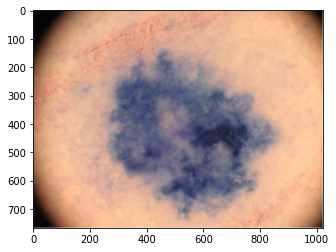

[[-0.22143006324768066, 0.40931859612464905, -0.17684271931648254]]
nevus


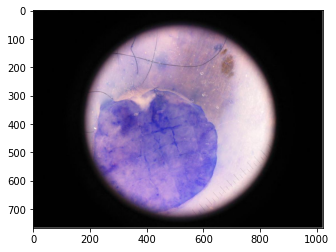

[[-0.026409247890114784, 0.46838319301605225, -0.28894492983818054]]
nevus


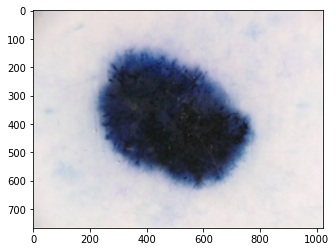

In [82]:
import matplotlib.pyplot as plt
import cv2
for file in np.hstack(human_files[:3]):
    predict_skin_cancer(file)
    img = cv2.imread(file)
    plt.imshow(img)
    plt.show()
    